# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_209  Q96AQ6;Q96AQ6-2   14.836
Sample_207  Q9UJA9            17.136
Sample_097  Q9Y6C2            13.630
Sample_091  P01624            23.124
Sample_165  Q08174-2          16.705
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups      
Sample_074  O76070                 13.507
Sample_042  E9PK25;G3V1A4;P23528   14.797
Sample_133  Q96SM3                 14.856
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.998
            A0A075B6Q5                 13.513
            A0A075B6R2                 13.721
            A0A075B6S5                 13.529
            A0A087WSY4                 13.522
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.857
            Q9UI40;Q9UI40-2            13.076
            Q9UIW2                     13.038
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.529
            Q9UP79                     12.159
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.054,15.050,16.842,19.863,16.107,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.027,19.067,...,15.528,15.576,14.644,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.147,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.051,17.705,17.039,15.857,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.480,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.260,15.345,17.084,18.708,14.249,19.433,11.628,11.134
Sample_207,15.739,16.877,15.469,16.898,14.769,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.998,...,16.012,15.178,13.741,15.050,16.842,19.863,13.050,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.152,19.067,16.188,...,15.528,15.576,12.683,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.579,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.566,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.360,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.707,15.345,17.084,18.708,14.249,19.433,13.055,12.805
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 371.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.52it/s]

100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

100%|██████████| 3/3 [00:00<00:00,  3.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.77it/s]

100%|██████████| 4/4 [00:01<00:00,  3.61it/s]

100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.21it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.65it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.33it/s]

100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.52it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.26it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.20it/s]

100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.80it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.61it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.96it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.73it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.50it/s]

100%|██████████| 7/7 [00:01<00:00,  3.44it/s]

100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.82it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.01it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.70it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.42it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.96it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.94it/s]

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.56it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.37it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.74it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.33it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.90it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.90it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.90it/s]

100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.51it/s]

 30%|███       | 3/10 [00:00<00:01,  4.34it/s]

 40%|████      | 4/10 [00:01<00:01,  3.61it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.47it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.33it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.16it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.24it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.14it/s]

100%|██████████| 10/10 [00:03<00:00,  2.90it/s]

100%|██████████| 10/10 [00:03<00:00,  3.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.73it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.58it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.06it/s]

 45%|████▌     | 5/11 [00:01<00:02,  3.00it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.09it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.91it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.72it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.72it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.84it/s]

100%|██████████| 11/11 [00:03<00:00,  2.82it/s]

100%|██████████| 11/11 [00:03<00:00,  2.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.57it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.53it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.98it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.15it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.99it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.94it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.05it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.17it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.82it/s]

100%|██████████| 12/12 [00:03<00:00,  2.56it/s]

100%|██████████| 12/12 [00:03<00:00,  3.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.13it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.90it/s]

 31%|███       | 4/13 [00:01<00:03,  2.59it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.37it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.14it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.16it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.10it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.13it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.97it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.81it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.82it/s]

100%|██████████| 13/13 [00:06<00:00,  1.84it/s]

100%|██████████| 13/13 [00:06<00:00,  2.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.55it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.65it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.34it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.08it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.88it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.90it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.99it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.05it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.04it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.13it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.13it/s]

100%|██████████| 14/14 [00:04<00:00,  3.20it/s]

100%|██████████| 14/14 [00:04<00:00,  3.19it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 10.41it/s]

 27%|██▋       | 4/15 [00:00<00:01,  6.24it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.39it/s]

 40%|████      | 6/15 [00:01<00:01,  4.98it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.76it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.87it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.36it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.17it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.03it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.87it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.82it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.77it/s]

100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

100%|██████████| 15/15 [00:03<00:00,  4.40it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.095 0.043          0.810 0.299       0.127   
2             0.004 0.002      0.058 0.024          0.703 0.090       0.604   
3             0.004 0.002      0.050 0.012          0.697 0.094       0.605   
4             0.004 0.002      0.052 0.013          0.746 0.079       0.649   
5             0.004 0.000      0.049 0.008          0.723 0.075       0.690   
6             0.004 0.000      0.051 0.011          0.804 0.086       0.799   
7             0.004 0.002      0.056 0.015          0.805 0.085       0.805   
8             0.005 0.004      0.053 0.014          0.810 0.080       0.818   
9             0.005 0.003      0.051 0.012          0.812 0.076       0.820   
10            0.004 0.003      0.052 0.010          0.801 0.075       0.822   
11            0.004 0.002      0.054 0.016          0.806 0.081       0.807   
12            0.008 0.006      0.087 0.031          0.821 0.079       0.808   
13            0.006 0.004      0.099 0.038          0.835 0.080       0.813   
14            0.003 0.001      0.041 0.011          0.833 0.080       0.809   
15            0.004 0.000      0.042 0.002          0.826 0.081       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.084   0.211 0.124                  0.556 0.041        0.855   
2          0.107   0.644 0.080                  0.707 0.059        0.788   
3          0.112   0.641 0.081                  0.704 0.060        0.782   
4          0.115   0.688 0.082                  0.742 0.060        0.806   
5          0.109   0.700 0.070                  0.747 0.053        0.806   
6          0.103   0.797 0.069                  0.826 0.059        0.899   
7          0.106   0.800 0.069                  0.829 0.059        0.898   
8          0.103   0.810 0.071                  0.838 0.061        0.913   
9          0.101   0.812 0.068                  0.839 0.059        0.913   
10         0.103   0.808 0.071                  0.836 0.062        0.910   
11         0.107   0.802 0.072                  0.831 0.062        0.910   
12         0.096   0.811 0.067                  0.838 0.055        0.919   
13         0.104   0.819 0.071                  0.846 0.059        0.921   
14         0.103   0.817 0.071                  0.844 0.058        0.919   
15         0.103   0.811 0.071                  0.840 0.059        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.065                  0.762 0.084        210.000 0.000  
3          0.065                  0.755 0.084        210.000 0.000  
4          0.060                  0.778 0.082        210.000 0.000  
5          0.059                  0.774 0.082        210.000 0.000  
6          0.046                  0.872 0.054        210.000 0.000  
7          0.047                  0.871 0.056        210.000 0.000  
8          0.046                  0.900 0.050        210.000 0.000  
9          0.047                  0.899 0.052        210.000 0.000  
10         0.047                  0.897 0.052        210.000 0.000  
11         0.046                  0.894 0.051        210.000 0.000  
12         0.046                  0.907 0.048        210.000 0.000  
13         0.047                  0.906 0.050        210.000 0.000  
14         0.046                  0.905 0.050        210.000 0.000  
15         0.047                  0.903 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 496.48it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.52it/s]

100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.83it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.29it/s]

100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.05it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.01it/s]

100%|██████████| 5/5 [00:01<00:00,  2.94it/s]

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.47it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.33it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.09it/s]

100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.24it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.75it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.34it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.16it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.44it/s]

100%|██████████| 7/7 [00:02<00:00,  1.98it/s]

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.48it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.03it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.30it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.87it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.66it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.64it/s]

100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.52it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.73it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.31it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.98it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.76it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.83it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.90it/s]

100%|██████████| 9/9 [00:04<00:00,  1.99it/s]

100%|██████████| 9/9 [00:04<00:00,  2.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.34it/s]

 30%|███       | 3/10 [00:01<00:02,  2.48it/s]

 40%|████      | 4/10 [00:01<00:03,  1.96it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.83it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.84it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.10it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.16it/s]

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.08it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.12it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.99it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.99it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.11it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.16it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.28it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.40it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.47it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.25it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.27it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.30it/s]

 42%|████▏     | 5/12 [00:02<00:02,  2.42it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.48it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.46it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.50it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.51it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.40it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.44it/s]

100%|██████████| 12/12 [00:04<00:00,  2.28it/s]

100%|██████████| 12/12 [00:04<00:00,  2.41it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.64it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.10it/s]

 31%|███       | 4/13 [00:01<00:03,  2.67it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.62it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.76it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.69it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.60it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.60it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.63it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.28it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  1.97it/s]

100%|██████████| 13/13 [00:05<00:00,  1.88it/s]

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.45it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.73it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.17it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.90it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.81it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.70it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.54it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.46it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.16it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.03it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.91it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.00it/s]

100%|██████████| 14/14 [00:05<00:00,  2.15it/s]

100%|██████████| 14/14 [00:05<00:00,  2.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.68it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.97it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.82it/s]

 40%|████      | 6/15 [00:02<00:03,  2.75it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.77it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.73it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.17it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.98it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.85it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.01it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.03it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.13it/s]

100%|██████████| 15/15 [00:06<00:00,  2.13it/s]

100%|██████████| 15/15 [00:06<00:00,  2.34it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.041 0.003          0.027 0.132       0.005   
2             0.004 0.002      0.050 0.019          0.647 0.132       0.453   
3             0.005 0.005      0.057 0.023          0.682 0.109       0.555   
4             0.004 0.003      0.052 0.016          0.685 0.106       0.556   
5             0.006 0.004      0.075 0.035          0.700 0.084       0.593   
6             0.007 0.006      0.078 0.030          0.683 0.099       0.601   
7             0.005 0.004      0.073 0.032          0.783 0.091       0.792   
8             0.004 0.002      0.055 0.016          0.781 0.091       0.790   
9             0.004 0.002      0.052 0.017          0.786 0.088       0.808   
10            0.004 0.003      0.053 0.021          0.789 0.083       0.811   
11            0.006 0.005      0.066 0.025          0.789 0.089       0.807   
12            0.005 0.003      0.060 0.025          0.790 0.087       0.815   
13            0.005 0.003      0.054 0.015          0.799 0.085       0.823   
14            0.006 0.005      0.060 0.020          0.808 0.086       0.825   
15            0.006 0.004      0.069 0.028          0.812 0.083       0.824   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.023   0.008 0.040                  0.498 0.011        0.858   
2          0.119   0.519 0.093                  0.628 0.058        0.707   
3          0.111   0.604 0.091                  0.680 0.064        0.738   
4          0.111   0.606 0.088                  0.682 0.061        0.732   
5          0.114   0.636 0.082                  0.703 0.057        0.787   
6          0.123   0.633 0.092                  0.697 0.068        0.787   
7          0.111   0.781 0.072                  0.813 0.060        0.895   
8          0.106   0.779 0.069                  0.811 0.058        0.892   
9          0.110   0.791 0.072                  0.822 0.060        0.891   
10         0.114   0.795 0.072                  0.825 0.061        0.893   
11         0.117   0.792 0.079                  0.823 0.066        0.903   
12         0.110   0.797 0.074                  0.827 0.063        0.905   
13         0.111   0.805 0.067                  0.833 0.057        0.908   
14         0.106   0.811 0.067                  0.839 0.057        0.908   
15         0.103   0.812 0.063                  0.840 0.054        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.829 0.088        210.000 0.000  
2          0.084                  0.623 0.103        210.000 0.000  
3          0.073                  0.703 0.088        210.000 0.000  
4          0.069                  0.696 0.081        210.000 0.000  
5          0.070                  0.760 0.088        210.000 0.000  
6          0.069                  0.755 0.087        210.000 0.000  
7          0.052                  0.862 0.068        210.000 0.000  
8          0.052                  0.859 0.068        210.000 0.000  
9          0.054                  0.859 0.068        210.000 0.000  
10         0.050                  0.862 0.062        210.000 0.000  
11         0.048                  0.879 0.057        210.000 0.000  
12         0.048                  0.882 0.059        210.000 0.000  
13         0.046                  0.885 0.058        210.000 0.000  
14         0.045                  0.886 0.056        210.000 0.000  
15         0.046                  0.885 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 958.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.11it/s]

100%|██████████| 2/2 [00:00<00:00, 16.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.04it/s]

100%|██████████| 3/3 [00:00<00:00, 17.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.33it/s]

100%|██████████| 4/4 [00:00<00:00, 15.63it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.89it/s]

100%|██████████| 5/5 [00:00<00:00, 12.05it/s]

100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 19.93it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.51it/s]

100%|██████████| 6/6 [00:00<00:00, 11.18it/s]

100%|██████████| 6/6 [00:00<00:00, 11.85it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.03it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.58it/s]

100%|██████████| 7/7 [00:00<00:00, 13.64it/s]

100%|██████████| 7/7 [00:00<00:00, 14.25it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 16.39it/s]

 50%|█████     | 4/8 [00:00<00:00, 12.86it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 11.61it/s]

100%|██████████| 8/8 [00:00<00:00, 12.04it/s]

100%|██████████| 8/8 [00:00<00:00, 12.26it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.82it/s]

 44%|████▍     | 4/9 [00:00<00:00, 10.61it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 10.80it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.72it/s]

100%|██████████| 9/9 [00:00<00:00, 10.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.50it/s]

 40%|████      | 4/10 [00:00<00:00, 14.69it/s]

 60%|██████    | 6/10 [00:00<00:00, 12.63it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.65it/s]

100%|██████████| 10/10 [00:00<00:00, 12.45it/s]

100%|██████████| 10/10 [00:00<00:00, 13.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.25it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.51it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.91it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.08it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.91it/s]

100%|██████████| 11/11 [00:01<00:00, 10.35it/s]

100%|██████████| 11/11 [00:01<00:00, 10.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.62it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.27it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.59it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.51it/s]

 83%|████████▎ | 10/12 [00:00<00:00,  9.68it/s]

100%|██████████| 12/12 [00:01<00:00,  9.36it/s]

100%|██████████| 12/12 [00:01<00:00, 10.18it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.69it/s]

 31%|███       | 4/13 [00:00<00:00, 13.54it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.53it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 12.26it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.61it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 11.71it/s]

100%|██████████| 13/13 [00:01<00:00, 12.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 19.01it/s]

 29%|██▊       | 4/14 [00:00<00:00, 13.18it/s]

 43%|████▎     | 6/14 [00:00<00:00, 11.50it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.15it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.18it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 11.37it/s]

100%|██████████| 14/14 [00:01<00:00, 10.50it/s]

100%|██████████| 14/14 [00:01<00:00, 11.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 13.95it/s]

 33%|███▎      | 5/15 [00:00<00:01,  9.19it/s]

 40%|████      | 6/15 [00:00<00:01,  8.65it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.49it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.31it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.24it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.46it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.80it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.87it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.02it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.51it/s]

100%|██████████| 15/15 [00:01<00:00,  8.32it/s]

100%|██████████| 15/15 [00:01<00:00,  8.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.056 0.024          0.000 0.000       0.000   
2             0.005 0.006      0.060 0.030          0.040 0.198       0.002   
3             0.006 0.005      0.080 0.035          0.497 0.288       0.100   
4             0.005 0.004      0.078 0.033          0.472 0.158       0.186   
5             0.004 0.001      0.050 0.013          0.527 0.123       0.273   
6             0.007 0.007      0.075 0.032          0.519 0.140       0.275   
7             0.006 0.005      0.074 0.026          0.480 0.144       0.255   
8             0.005 0.004      0.057 0.020          0.624 0.076       0.620   
9             0.005 0.004      0.072 0.029          0.663 0.073       0.634   
10            0.006 0.004      0.068 0.025          0.667 0.067       0.637   
11            0.004 0.000      0.052 0.016          0.669 0.067       0.651   
12            0.006 0.005      0.070 0.026          0.686 0.074       0.647   
13            0.006 0.004      0.066 0.022          0.685 0.083       0.636   
14            0.007 0.005      0.086 0.030          0.687 0.081       0.665   
15            0.007 0.006      0.068 0.026          0.685 0.082       0.658   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.753   
2          0.012   0.004 0.022                  0.501 0.007        0.613   
3          0.065   0.159 0.094                  0.512 0.039        0.567   
4          0.083   0.258 0.097                  0.517 0.039        0.588   
5          0.091   0.354 0.100                  0.548 0.053        0.611   
6          0.105   0.353 0.115                  0.546 0.062        0.592   
7          0.103   0.329 0.117                  0.531 0.061        0.582   
8          0.134   0.617 0.096                  0.676 0.072        0.766   
9          0.119   0.642 0.080                  0.699 0.059        0.808   
10         0.104   0.647 0.070                  0.702 0.053        0.810   
11         0.103   0.654 0.067                  0.707 0.053        0.810   
12         0.112   0.660 0.073                  0.714 0.058        0.822   
13         0.112   0.653 0.074                  0.709 0.058        0.820   
14         0.130   0.669 0.087                  0.721 0.067        0.827   
15         0.134   0.665 0.092                  0.718 0.071        0.824   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.705 0.076        210.000 0.000  
2          0.108                  0.639 0.097        210.000 0.000  
3          0.084                  0.518 0.074        210.000 0.000  
4          0.073                  0.517 0.074        210.000 0.000  
5          0.064                  0.545 0.065        210.000 0.000  
6          0.061                  0.531 0.063        210.000 0.000  
7          0.060                  0.524 0.066        210.000 0.000  
8          0.067                  0.694 0.081        210.000 0.000  
9          0.054                  0.748 0.069        210.000 0.000  
10         0.053                  0.754 0.068        210.000 0.000  
11         0.053                  0.753 0.067        210.000 0.000  
12         0.064                  0.768 0.077        210.000 0.000  
13         0.067                  0.767 0.081        210.000 0.000  
14         0.061                  0.786 0.071        210.000 0.000  
15         0.062                  0.781 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,6,14
score_time,13,6,14
test_precision,13,15,14
test_recall,10,14,14
test_f1,13,15,14
test_balanced_accuracy,13,15,14
test_roc_auc,13,14,14
test_average_precision,12,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.25it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.18it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.93it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.75it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.72it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.67it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.06it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.81it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.68it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.60it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.69it/s]

100%|██████████| 14/14 [00:06<00:00,  1.86it/s]

100%|██████████| 14/14 [00:06<00:00,  2.16it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.01it/s]

 29%|██▊       | 4/14 [00:00<00:00, 15.72it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.91it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.55it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.94it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.72it/s]

100%|██████████| 14/14 [00:01<00:00, 10.96it/s]

100%|██████████| 14/14 [00:01<00:00, 12.12it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.91it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.81it/s]

 31%|███       | 4/13 [00:01<00:03,  2.30it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.06it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.95it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.06it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.09it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.28it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.47it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.63it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.39it/s]

100%|██████████| 13/13 [00:05<00:00,  2.14it/s]

100%|██████████| 13/13 [00:05<00:00,  2.29it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


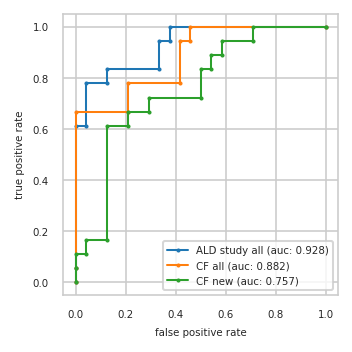

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.611  0.000 0.667  0.000 0.111
3          0.042 0.611  0.208 0.667  0.042 0.111
4          0.042 0.778  0.208 0.778  0.042 0.167
5          0.125 0.778  0.417 0.778  0.125 0.167
6          0.125 0.833  0.417 0.944  0.125 0.611
7          0.333 0.833  0.458 0.944  0.208 0.611
8          0.333 0.944  0.458 1.000  0.208 0.667
9          0.375 0.944  1.000 1.000  0.292 0.667
10         0.375 1.000    NaN   NaN  0.292 0.722
11         1.000 1.000    NaN   NaN  0.500 0.722
12           NaN   NaN    NaN   NaN  0.500 0.833
13           NaN   NaN    NaN   NaN  0.542 0.833
14           NaN   NaN    NaN   NaN  0.542 0.889
15           NaN   NaN    NaN   NaN  0.583 0.889
16           NaN   NaN    NaN   NaN  0.583 0.944
17           NaN   NaN    NaN   NaN  0.708 0.944
18           NaN   NaN    NaN   NaN  0.708 1.000
19           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,K7ER15;Q9H0R4;Q9H0R4-2,P43004;P43004-2;P43004-3
2,Q99969,P02741,P51688
3,P61981,P04075,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,Q96GD0
5,P14174,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,Q9Y2T3;Q9Y2T3-3,Q14894,Q9NUQ9
7,P00338;P00338-3,P14174,A0A075B7B8
8,C9JF17;P05090,P63104,O95497


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


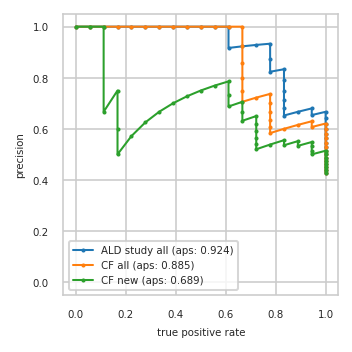

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.630 0.944     0.556 0.833
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.680 0.944     0.600 0.833     0.520 0.722
18         0.667 0.889     0.583 0.778     0.542 0.722
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.750 0.833     0.700 0.778     0.650 0.722
23         0.789 0.833     0.737 0.778     0.632 0.667
24         0.833 0.833     0.722 0.722     0.667 0.667
25         0.824 0.778     0.706 0.667     0.706 0.667
26         0.875 0.778     0.750 0.667     0.688 0.611
27         0.933 0.778     0.800 0.667     0.733 0.611
28         0.929 0.722     0.857 0.667     0.786 0.611
29         0.923 0.667     0.923 0.667     0.769 0.556
30         0.917 0.611     1.000 0.667     0.750 0.500
31         1.000 0.611     1.000 0.611     0.727 0.444
32         1.000 0.556     1.000 0.556     0.700 0.389
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


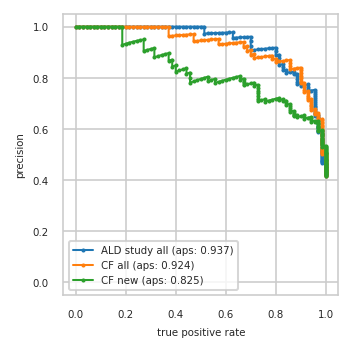

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


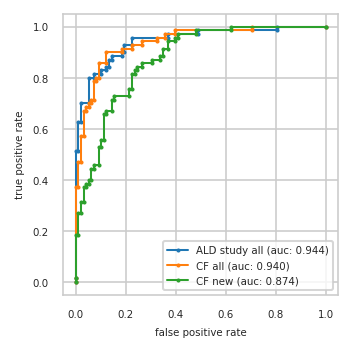

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}